In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

In [3]:
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [4]:
session = Session(engine)

In [5]:
start_date = '2017-04-22'
end_date = '2017-05-03'

In [6]:
def to_dt(date_str):
    return dt.datetime.strptime(date_str, '%Y-%m-%d')

def dt_str(date):
    return date.strftime('%Y-%m-%d')

def year_before(date_str):
    return dt_str(to_dt(date_str) - dt.timedelta(days=365))

### Precipitation Analysis

In [7]:
latest_date = session.query(func.max(Measurement.date)).all()[0][0]

In [8]:
year_ago = year_before(latest_date)

Take the average precipitation measurement for each date

In [9]:
prcp_query = session.query(Measurement.date,func.avg(Measurement.prcp))\
            .filter(Measurement.date > year_ago).group_by(Measurement.date).all()

In [10]:
prcp_dates = [x[0] for x in prcp_query]
prcp_levels = [x[1] for x in prcp_query]

In [11]:
prcp_df = pd.DataFrame({"prcp": prcp_levels}, index=prcp_dates)
prcp_df.head(10)

,prcp
2016-08-24,1.332857
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.053333
2016-08-28,0.516667
2016-08-29,0.208571
2016-08-30,0.011667
2016-08-31,0.454286
2016-09-01,0.005000
2016-09-02,0.035714


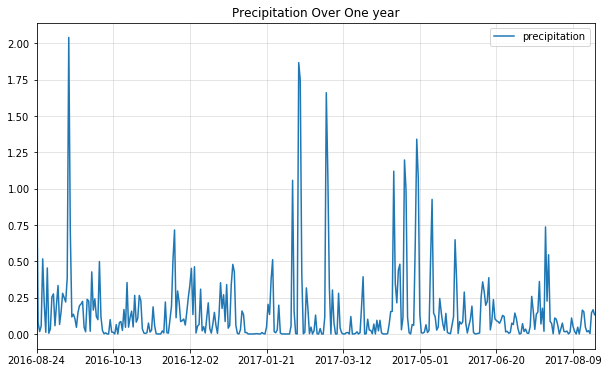

In [12]:
prcp_df.plot(figsize=[10,6],title="Precipitation Over One year").legend(["precipitation"])
plt.grid(alpha=0.4)
plt.show()

In [13]:
prcp_df.describe()

,prcp
count,365.000000
mean,0.156103
std,0.275657
min,0.000000
25%,0.008571
50%,0.065000
75%,0.175714
max,2.040000


### Station Analysis

In [14]:
session.query(Station).count()

9

In [15]:
session.query(Measurement.station, func.count(Measurement.date)).\
        group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
max_station = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.date > year_ago).\
                group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()[0][0]
tobs_query = session.query(Measurement.tobs).filter((Measurement.date > year_ago)\
                                                    &(Measurement.station==max_station)).all()
tobs_list = [x[0] for x in tobs_query]

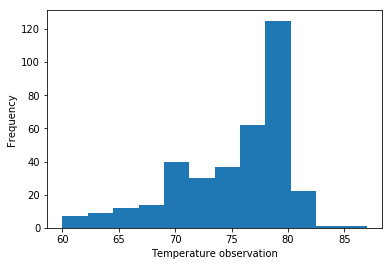

In [17]:
plt.hist(tobs_list, bins=12)
plt.xlabel("Temperature observation")
plt.ylabel("Frequency")
plt.show()

### Temperature Analysis

In [18]:
def calc_temps(start_date, end_date):
    start_ya = year_before(start_date)
    end_ya = year_before(end_date)
    temp_query = session.query(Measurement.tobs).filter((Measurement.date >= start_ya) & (Measurement.date <= end_ya)).all()
    temp_list = [x[0] for x in temp_query]
    min_temp = min(temp_list)
    max_temp = max(temp_list)
    avg_temp = np.average(temp_list)
    return {"min": min_temp, "max": max_temp, "avg": avg_temp}

In [19]:
trip_temp = calc_temps(start_date, end_date)
trip_temp

{'avg': 75.341772151898738, 'max': 79.0, 'min': 68.0}

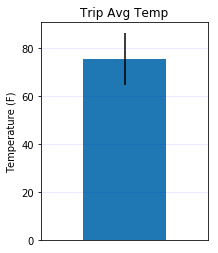

In [20]:
plt.figure(figsize=[3,4])
plt.grid(alpha=0.1,color="b")
plt.bar(0,trip_temp["avg"],1,yerr=(trip_temp["max"]-trip_temp["min"]))
plt.xlim([-1,1])
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.show()

### Rainfall per station

In [33]:
start_ya = year_before(start_date)
end_ya = year_before(end_date)

rps_query = session.query(Measurement.station, func.sum(Measurement.prcp))\
            .filter((Measurement.date >= start_ya) & (Measurement.date <= end_ya)).group_by(Measurement.station).all()

name_list = [session.query(Station.name).filter(Station.station == x[0]).first()[0] for x in rps_query]

print(f"\nTotal Rainfall Between {start_ya} and {end_ya}, per station:")
pd.DataFrame({"Rainfall":[x[1] for x in rps_query],"Station Name": name_list}, index=[x[0] for x in rps_query])


Total Rainfall Between 2016-04-22 and 2016-05-03, per station:


,Rainfall,Station Name
USC00513117,0.50,"KANEOHE 838.1, HI US"
USC00514830,0.45,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
USC00516128,3.39,"MANOA LYON ARBO 785.2, HI US"
USC00517948,0.00,"PEARL CITY, HI US"
USC00519281,0.85,"WAIHEE 837.5, HI US"
USC00519397,0.11,"WAIKIKI 717.2, HI US"
USC00519523,0.49,"WAIMANALO EXPERIMENTAL FARM, HI US"


### Daily Normals

In [45]:
def daily_normals(date_str):
    temp_query = session.query(Measurement.tobs).filter(Measurement.date.like(f"%{date_str}")).all()
    temp_list = [x[0] for x in temp_query]
    min_temp = min(temp_list)
    max_temp = max(temp_list)
    avg_temp = np.average(temp_list)
    return [min_temp, avg_temp, max_temp]

In [58]:
date_list=[x.strftime("%m-%d") for x in pd.date_range(start_date,end_date)]

In [65]:
normals_zip=[x for x in zip(*[daily_normals(x) for x in date_list])]

normals_list_min = list(normals_zip[0])
normals_list_avg = list(normals_zip[1])
normals_list_max = list(normals_zip[2])

In [79]:
normals_df = pd.DataFrame({"min": normals_list_min, "avg": normals_list_avg, "max": normals_list_max}, index=date_list)[["min","avg","max"]]
normals_df

,min,avg,max
04-22,65.0,72.927273,84.0
04-23,65.0,73.018182,79.0
04-24,67.0,73.310345,80.0
04-25,66.0,73.965517,83.0
04-26,66.0,74.017241,81.0
04-27,65.0,72.872727,81.0
04-28,63.0,73.464286,79.0
04-29,66.0,73.303571,81.0
04-30,58.0,71.557692,78.0
05-01,65.0,72.759259,79.0


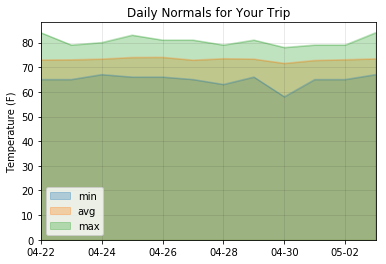

In [90]:
normals_df.plot.area(stacked=False, alpha=0.3)
plt.grid(color="k",alpha=0.1)
plt.title("Daily Normals for Your Trip")
#plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.show()